In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, dataloader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import json


class DataSplitter:

    def __init__(self, split_rate=0.8):
        self.split_rate = split_rate
        self.train_ids = None
        self.test_ids = None

    def split(self, infname: str, sep='\t', id_field='reaxys_id'):
        df = pd.read_csv(infname, sep=sep)
        unique_ids = df[id_field].unique()
        n_ids = unique_ids.shape[0]
        self.train_ids = np.random.choice(unique_ids,
                                          replace=False,
                                          size=int(self.split_rate*n_ids))
        self.test_ids = np.array([x for x in unique_ids if x not in self.train_ids])
        train = df[df[id_field].isin(self.train_ids)]
        test = df[df[id_field].isin(self.test_ids)]
        return train, test
        

class SmilesDataset(Dataset):

    def __init__(self, infname: str, sep='\t', fields_to_leave=['original', 'erroneous']):
        df = pd.read_csv(infname, sep=sep)
        df = df[fields_to_leave]
        # Tokenize
        self.token_map = self.get_token_map(df, fields_to_leave)
        self.num_to_token = {v : k for k, v in self.token_map.items()}
        df['erroneous'] = df['erroneous'].apply(lambda x: "BOS " + x + " EOS")
        df['original'] = df['original'].apply(lambda x: "BOS " + x + " EOS")
        self.inputs = [torch.LongTensor([self.token_map[t] for t in row.split()]) for row in df['erroneous']]
        self.labels = [torch.LongTensor([self.token_map[t] for t in row.split()]) for row in df['original']]
        self.input_lens = torch.LongTensor([len(x) for x in self.inputs])
        self.label_lens = torch.LongTensor([len(x) for x in self.labels])
        #max_inp_len = torch.max(self.input_lens).item()
        #max_label_len = torch.max(self.label_lens).item()
        #pad_len = max(max_inp_len, max_label_len)
        #self.inputs = torch.LongTensor([x + [0] * (pad_len - len(x)) for x in self.inputs])
        #self.labels = torch.LongTensor([x + [0] * (pad_len - len(x)) for x in self.labels])
        #assert self.inputs.shape[0] == self.labels.shape[0]
        #assert self.inputs.shape[1] == self.labels.shape[1]
        #assert self.input_lens.shape[0] == self.label_lens.shape[0]
        
    def save_token_map(self, out_fname: str):
        with open(out_fname, "w") as ostream:
            ostream.write(json.dumps(self.token_map))
        
    def get_token_map(self, df, fields_to_leave):
        token_map = {'PAD': 0, 'BOS': 1, 'EOS': 2}
        start_idx = 3
        token_set = set()
        for field in fields_to_leave:
            series = df[field]
            for entry in series:
                curr_set = set(entry.split())
                token_set = token_set.union(curr_set)
        for token in token_set:
            token_map[token] = len(token_map)
        return token_map
    
    @property
    def n_tokens(self):
        return len(self.token_map)

    def as_smiles(self, tokenized: list):
        return "".join([self.num_to_token[x] for x in tokenized])

    def __len__(self):
        #return self.inputs.shape[0]
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx], self.input_lens[idx], self.label_lens[idx]
    
    @staticmethod
    def collate(data):
        inps, labs, in_lens, lab_lens = zip(*data)
        inps = pad_sequence(inps)
        labs = pad_sequence(labs)
        in_lens = torch.stack(in_lens)
        lab_lens = torch.stack(lab_lens)
        return inps, labs, in_lens, lab_lens


In [2]:
dataset = SmilesDataset('train_split.tsv')

In [7]:
import matplotlib.pyplot as plt

(array([2.62799e+05, 3.81716e+05, 2.76385e+05, 1.03958e+05, 3.08330e+04,
        1.16140e+04, 5.01600e+03, 2.15700e+03, 6.15000e+02, 1.04000e+02]),
 array([  3. ,  22.4,  41.8,  61.2,  80.6, 100. , 119.4, 138.8, 158.2,
        177.6, 197. ]),
 <a list of 10 Patch objects>)

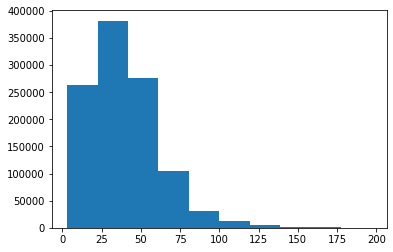

In [8]:
plt.hist(dataset.label_lens)

In [3]:
loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=SmilesDataset.collate)

In [4]:
for batch in loader:
    break

In [7]:
batch[0].shape

torch.Size([118, 64])

In [9]:
emb = nn.Embedding(num_embeddings=dataset.n_tokens, embedding_dim=128, padding_idx=0)

In [29]:
pe = PositionalEncoding(128)

In [31]:
pe.pe.shape

torch.Size([5000, 1, 128])

In [33]:
x = pe(emb(batch[0]))

In [38]:
x.shape

torch.Size([118, 64, 128])

In [16]:
model = Transformer(dataset.n_tokens, 64, 2, 64, 2)

In [17]:
out = model(batch[0])

In [21]:
model.decoder(out[0][:1], out[1])

ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
import math
from torch import nn
import torch


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class Transformer(nn.Module):
    
    def __init__(self, n_emb, d_model, n_heads, h_dim, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(n_emb, d_model, padding_idx=0)
        self.positional = PositionalEncoding(d_model)
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, n_heads, h_dim),
                                             n_layers)
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model, n_heads, h_dim),
                                             n_layers)
        self.out_linear = nn.Linear(d_model, n_emb)

    @staticmethod
    def get_square_subsequent_mask(size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, max_iter=200, bos_idx=1):
        # Work in progress
        x = self.embedding(x)
        x = self.positional(x)
        memory = self.encoder(x)
        curr_seq = torch.zeros(max_iter, x.shape[0], dtype=torch.long)
        curr_seq[0] = torch.full((x.shape[0], ), bos_idx)
        logits = []
        return curr_seq, memory
        for i in range(max_iter):
            x = self.decoder(curr_seq[:i+1], memory)
            x = self.out_linear(x)
            return x
        return x


class Trainer:

    def __init__(self, model, log_folder: str, weight_folder: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.log_folder = log_folder
        self.weight_folder = weight_folder

    def fit(self, dataset):
        pass

    def log(self):
        pass
    
    def save_model(self):
        pass

In [14]:
z = torch.zeros(200, 21, dtype="torch.Long")

In [18]:
z[:1].shape

torch.Size([1, 21])

In [9]:
torch.full((1,), 1).shape

torch.Size([1])